In [1]:
from sklearn import linear_model
from scipy.stats import t,laplace,norm,multivariate_normal
import numpy as np
from math import sqrt
from sklearn import model_selection
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
from mpl_toolkits import mplot3d
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib notebook

# Mapping Objective Functions
First thing we will talk about is to "visualize" an objective function.

Consider the squared loss function discussed in class:

$$
J(w_0,w) = \frac{1}{2}\sum_{i=1}^N(y_i - (w_0 + wx_i))^2
$$

In [3]:
# consider the following training data
df = pd.read_csv('../data/flu1d.csv')
df

,#numtweets,#numflucases
0,12,9
1,28,15
2,15,11
3,48,21
4,56,22


<IPython.core.display.Javascript object>


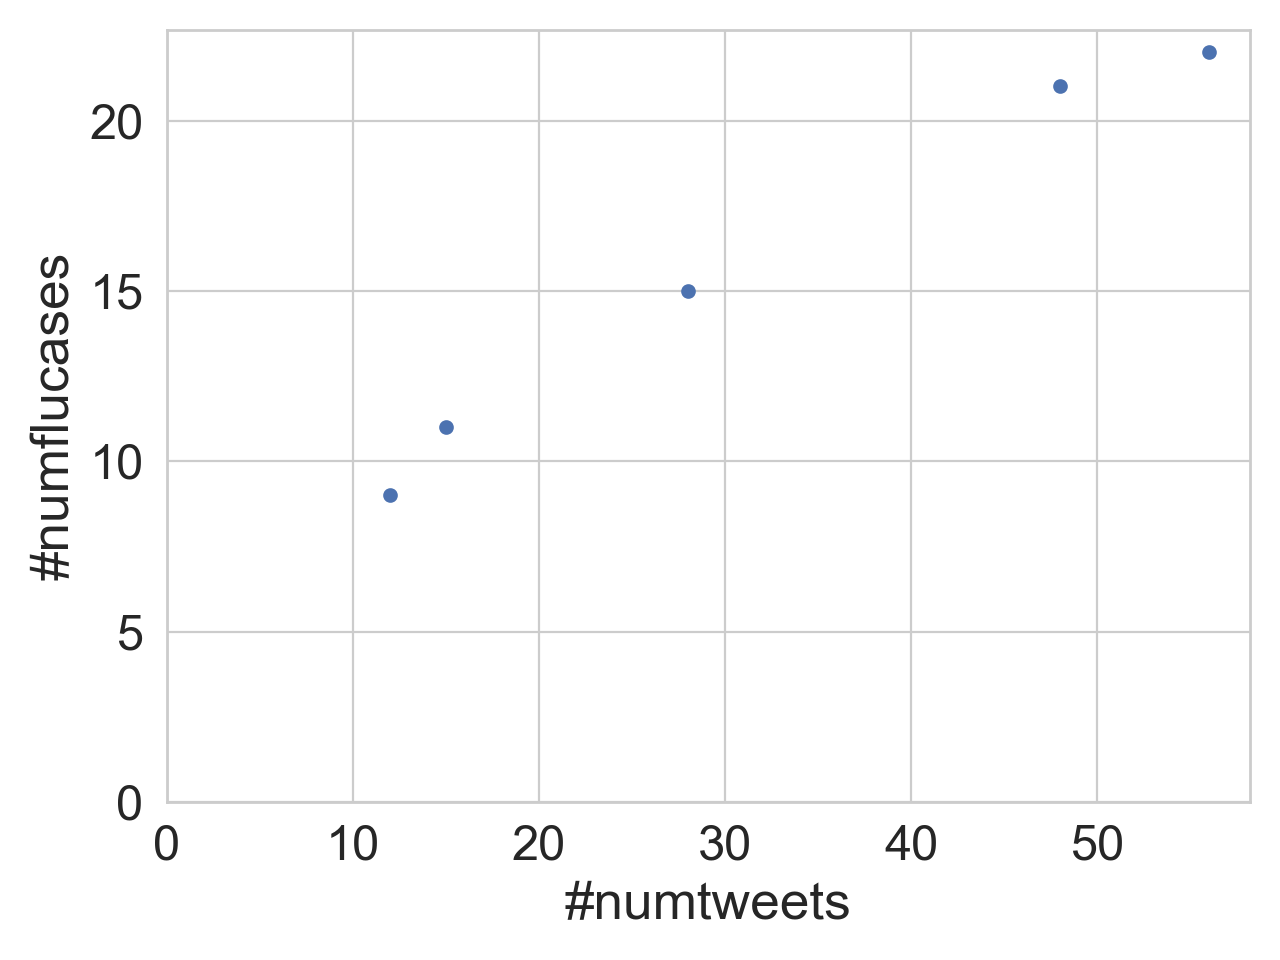

In [4]:
# plot the data
ax = df.plot.scatter(x='#numtweets',y='#numflucases',c='b')
ax.set_ylim(0,)
ax.set_xlim(0,)
plt.tight_layout()

In [5]:
# convert data to a np array
X = np.array(df['#numtweets'])
y = np.array(df['#numflucases'])

In [33]:
def objfunction(w,w0,X,y):
    J = 0.5*np.sum((y - (w*X + w0))**2)
    return J

In [64]:
# compute the objective function for a range of values for w and w0
ws = np.linspace(-20, 20, 40)
w0s = np.linspace(-20, 20, 40)
W, W0 = np.meshgrid(ws, w0s)
Js = []
for w,w0 in zip(W.flatten(),W0.flatten()):
    Js.append(objfunction_l0(w,w0,X,y))

Js = np.array(Js)
Js = np.reshape(Js,(len(ws),len(w0s)))    

<IPython.core.display.Javascript object>


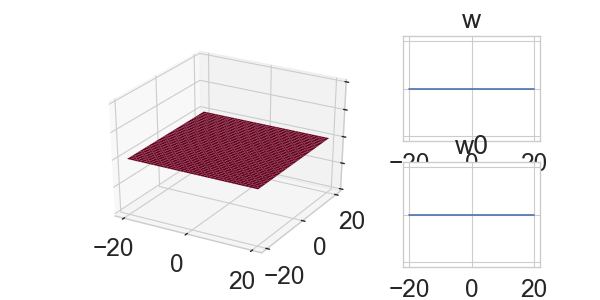

Text(0.5, 1.0, 'w0')

In [65]:
fig = plt.figure(figsize=(6,3))
grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0:2,0:2],projection='3d')
ax.plot_surface(W, W0, Js, rstride=1, cstride=1,
                cmap='RdGy', edgecolor='none')
ax.set_zticklabels([])

ax = fig.add_subplot(grid[0,2])
ax.plot(ws,Js[0,:])
ax.set_yticklabels([])
ax.set_title('w')

ax = fig.add_subplot(grid[1,2])
ax.plot(w0s,Js[:,20])
ax.set_yticklabels([])
ax.set_title('w0')


In [60]:
def objfunction_l1(w,w0,X,y):
    J = np.sum(np.abs(y - (w*X + w0)))
    return J

In [63]:
def objfunction_l0(w,w0,X,y):
    J = len(np.where(y == (w*X + w0))[0])
    return J

### Boston Housing Data

| Num | Feature   | Description |
| --- | --------- | ------------ | 
|1. | CRIM     |per capita crime rate by town |
|2. |ZN        |proportion of residential land zoned for lots over 25,000 sq.ft.|
|3. |INDUS     |proportion of non-retail business acres per town|
|4. |CHAS      |Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|5. |NOX       |nitric oxides concentration (parts per 10 million)|
|6. |RM        |average number of rooms per dwelling|
|7. |AGE       |proportion of owner-occupied units built prior to 1940|
|8. |DIS       |weighted distances to five Boston employment centres|
|9. |RAD       |index of accessibility to radial highways|
|10. |TAX      |full-value property-tax rate per 10,000|
|11. |PTRATIO  |pupil-teacher ratio by town|
|12. |B        |$1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town|
|13. |LSTAT    |\% lower status of the population|
|14. |MEDV     |Median value of owner-occupied homes in \$1000's|

In [ ]:
boston_data = load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston.head()

In [ ]:
plt.scatter(df_boston['RM'],df_boston['target'])

### Numerical instability

In [ ]:
X = np.array([[1,3,4,7],[1,4,2,6],[1,8,-3,5],[1,4,7,11],[1,3,2,5]])
print(X)

In [ ]:
np.linalg.inv(np.dot(X.transpose(),X))

### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\alpha_k$ to minimize $f(x_k+\alpha_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [ ]:
def f(x):
    return x**3-2*x**2+2

In [ ]:
def f_prime(x):
    return 3*x**2-4*x

In [ ]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

In [ ]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))


In [ ]:
plt.figure(figsize=[10,6])
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.annotate(xy=(x_list[0],f(x_list[0])),
             xytext=(x_list[0]+1,f(x_list[0])+1),
             s='start',
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(xy=(x_list[-1],f(x_list[-1])),
             xytext=(x_list[-1]-1,f(x_list[-1])),
             s='end',
             arrowprops=dict(facecolor='green', shrink=0.05),)
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")

Consider another function:
$$
f(x,y) = 5\cos(x - 2) + 5\sin(x - 2y)
$$
The derivative of this function will be:
$$
\nabla f = \left[\begin{array}{c}-5\sin(x-2) + 5\cos(x - 2y) \\ -10\cos(x-2y) \end{array}\right]
$$

In [ ]:
def f2(x,y):
    return 5*np.cos(x -2) + 5*np.sin(x - 2*y)

In [ ]:
def f2_prime(x,y):
    return np.array([-5*np.sin(x -2) + 5*np.cos(x - 2*y),-10*np.cos(x-2*y)])

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

X, Y = np.meshgrid(x, y)
Z = f2(X, Y)

In [ ]:
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0,0:2],projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='RdGy', edgecolor='none')
ax = fig.add_subplot(grid[0,2:])
ax.contourf(X, Y, Z, 20, cmap='RdGy')


In [ ]:
x_old = np.array([0,0])
x_new = np.array([1,1]) 
n_k = 0.01 # step size
precision = 0.0001

x_list, y_list = [x_new], [f2(x_new[0],x_new[1])]
while np.sum(np.abs(x_new - x_old)) > precision:
    x_old = x_new
    s_k = -f2_prime(x_old[0],x_old[1])
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f2(x_new[0],x_new[1]))
x_list = np.array(x_list)
y_list = np.array(y_list)

In [ ]:
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0,0:2],projection='3d')
ax.plot(x_list[:,0],x_list[:,1],y_list,c="r")
ax.scatter(x_list[:,0],x_list[:,1],y_list,c="r")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='RdGy', edgecolor='none',alpha=0.3)

ax = fig.add_subplot(grid[0,2:])
mp=ax.contourf(X, Y, Z, 20, cmap='RdGy')
ax.plot(x_list[:,0],x_list[:,1],c="r")
ax.annotate(xy=(x_list[0,0],x_list[0,1]),
             xytext=(x_list[0,0]+1,x_list[0,1]+1),
             s='start',
             arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate(xy=(x_list[-1,0],x_list[-1,1]),
             xytext=(x_list[-1,0]+1,x_list[-1,1]+1),
             s='end',
             arrowprops=dict(facecolor='green', shrink=0.05))

### Ordinary Linear Regression

In [ ]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

In [ ]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,sqrt(sigma2),x.shape[0])
plt.scatter(x,y)

In [ ]:
def calculateSquaredLoss(X,y,w):
    X1 = np.hstack([np.ones([X.shape[0],1]),X])
    ypred = np.dot(X1,w)
    return 0.5*np.sum(np.power(ypred - y,2))

In [ ]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

In [ ]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest,ytest, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

In [ ]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [ ]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))


In [ ]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Using robust regression
The statsmodels package has a robust linear regression model function (rlm) 

In [ ]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([np.ones(x.shape[0]),x.flatten()]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print(pretty_print_linear(w[1:],w[0]))


In [ ]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = w[0] + w[1]*xtest
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Handling outliers using other distributions
Below are some alternate distributions with less fat tail than Gaussian.

#### Laplace distribution
The distribution is defined using two parameters: $\mu$ and $b$. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{1}{2b}\exp\left(-\frac{\vert x - \mu\vert}{b}\right)$$

#### Student-t distribution
The distribution is defined using one parameter: $\nu$ or degrees of freedom. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu\pi}{\Gamma\left(\frac{\nu}{2}\right)}}\left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$


In [ ]:
# comparing student-t, norm, laplace
s = np.linspace(-10,10, 100)
df = 2.74335149908
plt.plot(s, laplace.pdf(s),'r-', lw=2, alpha=0.6, label='Laplace pdf')#assuming b = 1 and \mu = 0
#plt.plot(s, t.pdf(s,df),'b-', lw=2, alpha=0.6, label='Student-t pdf')#nu = df
plt.plot(s, norm.pdf(s,0,2),'k-', lw=2, alpha=0.6, label='Gaussian pdf')
plt.legend()

### Demonstrating Non-linear Regression
Also how to control the overfitting using Ridge Regression

In [ ]:
rng = np.random.RandomState(0)
# Generate sample data
np.random.seed(0)
n_samples = 30
true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2
X = X[:,np.newaxis]
plt.scatter(X,y, c='k', label='data')
plt.legend()

In [ ]:
X2 = X**2
Xhat = np.hstack([X,X2])

In [ ]:
lrmodel1 = LinearRegression()
lrmodel1.fit(X,y)
pretty_print_linear(lrmodel1.coef_,lrmodel1.intercept_)

In [ ]:
lrmodel2 = LinearRegression()
lrmodel2.fit(Xhat,y)
pretty_print_linear(lrmodel2.coef_,lrmodel2.intercept_)

In [ ]:
X_all = np.linspace(0, 1, 100)
X_all = X_all[:,np.newaxis]
y_all=lrmodel1.predict(X_all)
plt.plot(X_all,y_all)
plt.scatter(X,y, c='k', label='data')

In [ ]:
y_all2.shape

In [ ]:
X_all2 = np.hstack([X_all,X_all**2])
y_all2=lrmodel2.predict(X_all2)
fig = plt.figure()
plt.plot(X_all,y_all2)
plt.scatter(X,y, c='k', label='data')

In [ ]:
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=12,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)

# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
plt.scatter(X,y, c='k', label='data')
plt.legend()

In [ ]:
pretty_print_linear(lrmodel1.coef_,lrmodel1.intercept_)

In [ ]:
lrmodel1.coef_[-1] = 0

In [ ]:
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=10,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)
# fit ridge regression model on expanded features
rrmodel = Ridge(alpha=10)
pipeline1 = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge_regression", rrmodel)])
pipeline1.fit(X,y)

# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,3)
plt.plot(X_all, pipeline1.predict(X_all[:, np.newaxis]),color='b')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Using Ridge Regression to Control Impact of correlated variables

In [ ]:
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

In [ ]:
# adding correlated variables
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print("Linear model:", pretty_print_linear(lr.coef_,lr.intercept_))
 

In [ ]:
# handling correlated variables through Ridge Regression
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    ridge = Ridge(alpha=0.1)
    ridge.fit(X,Y)
    print("Ridge model:", pretty_print_linear(ridge.coef_,ridge.intercept_))


### Using LASSO to control overfitting

In [ ]:
# fit LASSO on expanded features
llmodel = Lasso(alpha=10)
pipeline2 = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso_regression", llmodel)])
pipeline2.fit(X,y)
# plot the fitted lines
X_all = np.linspace(0, 1, 100)
plt.plot(X_all, pipeline2.predict(X_all[:, np.newaxis]),label='Lasso Fit')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Demonstrating the role of Lasso in inducing sparsity
We will use the Boston housing data set to study this phenomenon

In [ ]:
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]

In [ ]:
# fit linear regression
lrmodel = Ridge(alpha=0.1)
lrmodel.fit(X, Y)
scores = -np.mean(cross_validation.cross_val_score(lrmodel,
    X, Y, scoring="mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
print("Linear regression model: ", pretty_print_linear(lrmodel.coef_, lrmodel.intercept_, names, sort = True))

In [ ]:
# fit Lasso
lasso = Lasso(alpha=0.3)
lasso.fit(X, Y)
scores = -np.mean(cross_validation.cross_val_score(lasso,
    X, Y, scoring="mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
print("Lasso model: ", pretty_print_linear(lasso.coef_, lasso.intercept_, names, sort = True))

In [ ]:
# comparing the two for sparsity
fig = plt.figure(figsize=[12,6])
plt.bar(range(1,len(lrmodel.coef_)+1),lrmodel.coef_,color='red',width=0.33,alpha=0.6)
plt.bar(np.arange(1.33,len(lrmodel.coef_)+1),lasso.coef_,color='green',width=0.33,alpha=0.6)
plt.legend(['Linear Regression', 'Lasso'])

$$x^3 - 6x^2 - 21x + 9$$

$$3x^2 - 12x - 21$$